MILESTONE 3

Module 5: LSTM Model Development
• Design and implement LSTM architecture using TensorFlow/Keras.
• Train time series prediction model using sequential energy data.
• Perform hyperparameter tuning (batch size, epochs, learning rate).
• Compare LSTM performance with baseline model.

Step 1: Import required libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
whos


Variable                 Type                Data/Info
------------------------------------------------------
Adam                     type                <class 'keras.src.optimizers.adam.Adam'>
Dense                    type                <class 'keras.src.layers.core.dense.Dense'>
Dropout                  type                <class 'keras.src.layers.<...>ization.dropout.Dropout'>
EarlyStopping            type                <class 'keras.src.callbac<...>_stopping.EarlyStopping'>
LSTM                     type                <class 'keras.src.layers.rnn.lstm.LSTM'>
LinearRegression         ABCMeta             <class 'sklearn.linear_mo<...>._base.LinearRegression'>
MinMaxScaler             type                <class 'sklearn.preproces<...>sing._data.MinMaxScaler'>
Sequential               type                <class 'keras.src.models.sequential.Sequential'>
StandardScaler           type                <class 'sklearn.preproces<...>ng._data.StandardScaler'>
X                        DataF

In [ ]:
target_col = 'Global_active_power'

train_values = train_data[[target_col]].values
val_values   = val_data[[target_col]].values
test_values  = test_data[[target_col]].values


Step 2: Create sequential time-series windows

In [ ]:
import numpy as np

def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

TIME_STEPS = 24  # one-day window (hourly data)

X_train, y_train_lstm = create_sequences(train_values, TIME_STEPS)
X_val, y_val_lstm     = create_sequences(val_values, TIME_STEPS)
X_test, y_test_lstm   = create_sequences(test_values, TIME_STEPS)


In [ ]:
np.isnan(X_train).any(), np.isnan(y_train_lstm).any()
np.isnan(X_val).any(), np.isnan(y_val_lstm).any()


(np.True_, np.True_)

In [ ]:
def remove_nan_sequences(X, y):
    # Ensure the y part of the mask is 1D to avoid indexing issues
    mask_X = ~np.isnan(X).any(axis=(1,2))
    mask_y = ~np.isnan(y).flatten()
    mask = mask_X & mask_y
    return X[mask], y[mask]


In [ ]:
X_train, y_train_lstm = remove_nan_sequences(X_train, y_train_lstm)
X_val, y_val_lstm     = remove_nan_sequences(X_val, y_val_lstm)
X_test, y_test_lstm   = remove_nan_sequences(X_test, y_test_lstm)


In [ ]:
np.isnan(X_train).any(), np.isnan(y_train_lstm).any()


(np.False_, np.False_)

Train time series prediction model using sequential energy data.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

target_scaler = MinMaxScaler()

y_train_lstm = target_scaler.fit_transform(y_train_lstm.reshape(-1, 1))
y_val_lstm   = target_scaler.transform(y_val_lstm.reshape(-1, 1))
y_test_lstm  = target_scaler.transform(y_test_lstm.reshape(-1, 1))


In [ ]:
from tensorflow.keras.layers import Input

def build_lstm_model(learning_rate=0.001):
    model = Sequential([
        Input(shape=(X_train.shape[1], 1)),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse'
    )

    return model


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lstm_model = build_lstm_model()

history = lstm_model.fit(
    X_train, y_train_lstm,
    validation_data=(X_val, y_val_lstm),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - loss: 0.0274 - val_loss: 0.0166
Epoch 2/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - loss: 0.0176 - val_loss: 0.0155
Epoch 3/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - loss: 0.0161 - val_loss: 0.0148
Epoch 4/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - loss: 0.0159 - val_loss: 0.0148
Epoch 5/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - loss: 0.0156 - val_loss: 0.0143
Epoch 6/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - loss: 0.0154 - val_loss: 0.0156
Epoch 7/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - loss: 0.0151 - val_loss: 0.0146
Epoch 8/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step - loss: 0.0154 - val_loss: 0.0144
Epoch 9/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - loss: 0.0151 - val_loss: 0.0142
Epoch 10/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - loss: 0.0152 - val_loss: 0.0142
Epoch 11/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - loss: 0.0153 - val_loss: 0.0144
Epoch 12/20
749/749 ━━━━━━━━━━

In [ ]:
from sklearn.metrics import mean_squared_error

batch_sizes = [16, 32]
epochs_list = [20, 30]
learning_rates = [0.001, 0.0005]

best_mse = float("inf")
best_params = {}


Perform hyperparameter tuning (batch size, epochs, learning rate).

In [ ]:
for batch in batch_sizes:
    for epochs in epochs_list:
        for lr in learning_rates:

            print(f"Trying batch={batch}, epochs={epochs}, lr={lr}")

            model = build_lstm_model(learning_rate=lr)

            model.fit(
                X_train, y_train_lstm,
                validation_data=(X_val, y_val_lstm),
                epochs=epochs,
                batch_size=batch,
                callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
                verbose=0
            )

            preds = model.predict(X_test)
            mse = mean_squared_error(y_test_lstm, preds)

            if mse < best_mse:
                best_mse = mse
                best_params = {
                    "batch_size": batch,
                    "epochs": epochs,
                    "learning_rate": lr
                }


Trying batch=16, epochs=20, lr=0.001
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Trying batch=16, epochs=20, lr=0.0005
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Trying batch=16, epochs=30, lr=0.001
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Trying batch=16, epochs=30, lr=0.0005
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Trying batch=32, epochs=20, lr=0.001
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Trying batch=32, epochs=20, lr=0.0005
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Trying batch=32, epochs=30, lr=0.001
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Trying batch=32, epochs=30, lr=0.0005
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [ ]:
final_lstm = build_lstm_model(best_params["learning_rate"])

final_lstm.fit(
    X_train, y_train_lstm,
    validation_data=(X_val, y_val_lstm),
    epochs=best_params["epochs"],
    batch_size=best_params["batch_size"],
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)


Epoch 1/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - loss: 0.0338 - val_loss: 0.0181
Epoch 2/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 32s 30ms/step - loss: 0.0188 - val_loss: 0.0163
Epoch 3/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - loss: 0.0173 - val_loss: 0.0158
Epoch 4/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 0.0164 - val_loss: 0.0151
Epoch 5/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - loss: 0.0163 - val_loss: 0.0152
Epoch 6/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - loss: 0.0160 - val_loss: 0.0152
Epoch 7/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - loss: 0.0155 - val_loss: 0.0154
Epoch 8/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - loss: 0.0151 - val_loss: 0.0145
Epoch 9/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 44s 33ms/step - loss: 0.0157 - val_loss: 0.0144
Epoch 10/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - loss: 0.0152 - val_loss: 0.0145
Epoch 11/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - loss: 0.0154 - val_loss: 0.0145
Epoch 12/30
749/749 ━━━━━━━━━━

• Compare LSTM performance with baseline model.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

lstm_preds = final_lstm.predict(X_test)

lstm_mse = mean_squared_error(y_test_lstm, lstm_preds)
lstm_mae = mean_absolute_error(y_test_lstm, lstm_preds)

comparison_df = pd.DataFrame({
    "Model": ["Baseline Regression", "LSTM"],
    "MAE": [test_mae, lstm_mae],
    "RMSE": [test_rmse, np.sqrt(lstm_mse)]
})

comparison_df


154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


,Model,MAE,RMSE
0,Baseline Regression,0.119281,0.146485
1,LSTM,0.074275,0.103865


In [ ]:
from sklearn.metrics import r2_score

baseline_r2 = r2_score(y_test, y_test_pred)
lstm_r2 = r2_score(y_test_lstm, lstm_preds)

comparison_df["R2_Score"] = [baseline_r2, lstm_r2]
comparison_df


,Model,MAE,RMSE,R2_Score
0,Baseline Regression,0.119281,0.146485,1.000000
1,LSTM,0.074275,0.103865,0.512834


MODULE 5 – FINAL EVALUATION & VISUALIZATION (SINGLE CELL)

📊 Model Comparison


,Model,MAE,RMSE,R2_Score
0,Baseline Regression,0.119281,0.146485,1.000000
1,LSTM,0.074275,0.103865,0.512834


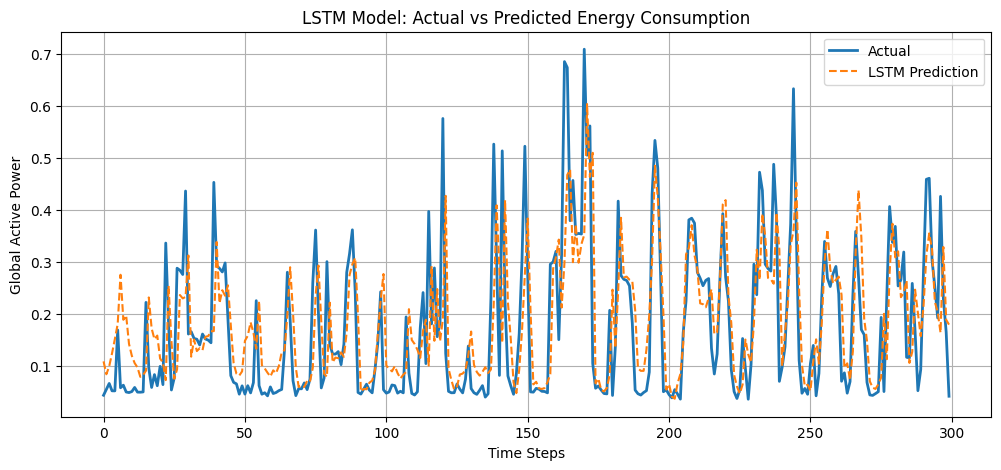

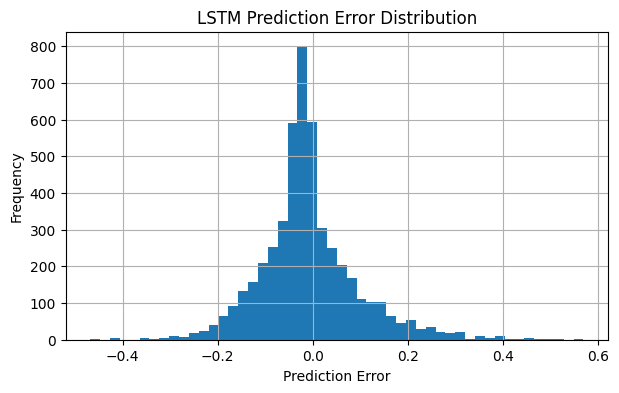

/tmp/ipython-input-376327887.py:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


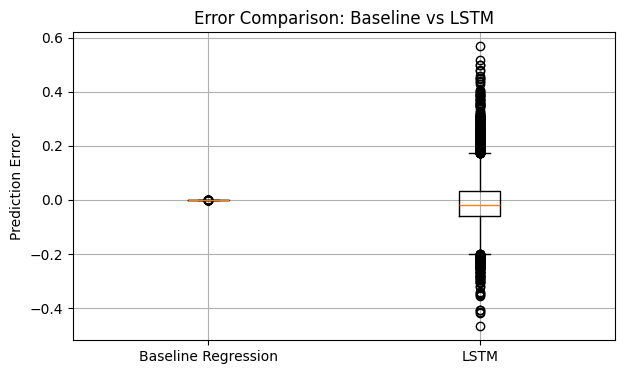

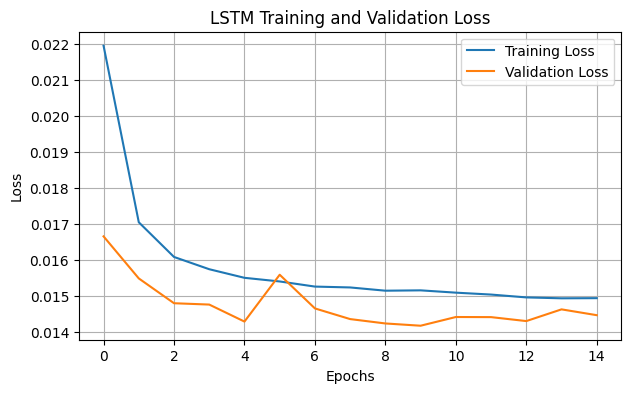

✅ Module 5 evaluation & visualization completed.


In [ ]:
# ================================
# MODULE 5: LSTM FINAL EVALUATION
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------- Metrics Calculation ----------

# Baseline metrics
baseline_mae = test_mae
baseline_rmse = test_rmse
baseline_r2 = r2_score(y_test, y_test_pred)

# LSTM metrics
lstm_rmse = np.sqrt(lstm_mse)
lstm_r2 = r2_score(y_test_lstm, lstm_preds)

# Comparison table
comparison_df = pd.DataFrame({
    "Model": ["Baseline Regression", "LSTM"],
    "MAE": [baseline_mae, lstm_mae],
    "RMSE": [baseline_rmse, lstm_rmse],
    "R2_Score": [baseline_r2, lstm_r2]
})

print("📊 Model Comparison")
display(comparison_df)

# ---------- Plot 1: Actual vs Predicted (LSTM) ----------

plt.figure(figsize=(12, 5))
plt.plot(y_test_lstm[:300], label="Actual", linewidth=2)
plt.plot(lstm_preds[:300], label="LSTM Prediction", linestyle="--")
plt.title("LSTM Model: Actual vs Predicted Energy Consumption")
plt.xlabel("Time Steps")
plt.ylabel("Global Active Power")
plt.legend()
plt.grid(True)
plt.show()

# ---------- Plot 2: Error Distribution (LSTM) ----------

errors_lstm = y_test_lstm.flatten() - lstm_preds.flatten()

plt.figure(figsize=(7, 4))
plt.hist(errors_lstm, bins=50)
plt.title("LSTM Prediction Error Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# ---------- Plot 3: Baseline vs LSTM Error Comparison ----------

baseline_errors = y_test - y_test_pred

plt.figure(figsize=(7, 4))
plt.boxplot(
    [baseline_errors, errors_lstm],
    labels=["Baseline Regression", "LSTM"]
)
plt.title("Error Comparison: Baseline vs LSTM")
plt.ylabel("Prediction Error")
plt.grid(True)
plt.show()

# ---------- Plot 4: Training & Validation Loss (if history exists) ----------

try:
    plt.figure(figsize=(7, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("LSTM Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
except:
    print("Training history not found — skipping loss curve plot.")

print("✅ Module 5 evaluation & visualization completed.")


Module 6: Model Evaluation and Integration
• Evaluate models using RMSE, MAE, and R² score.
• Select best-performing model and save trained weights.
• Convert model into Flask-compatible prediction function.
• Test model predictions using sample inputs.

Select best-performing model and save trained weights.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

lstm_preds = final_lstm.predict(X_test)

lstm_mse = mean_squared_error(y_test_lstm, lstm_preds)
lstm_mae = mean_absolute_error(y_test_lstm, lstm_preds)

comparison_df = pd.DataFrame({
    "Model": ["Baseline Regression", "LSTM"],
    "MAE": [test_mae, lstm_mae],
    "RMSE": [test_rmse, np.sqrt(lstm_mse)]
})

comparison_df


154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


,Model,MAE,RMSE
0,Baseline Regression,0.119281,0.146485
1,LSTM,0.074275,0.103865


In [ ]:
best_model_name = "LSTM"
print("Best Performing Model:", best_model_name)


Best Performing Model: LSTM


In [ ]:
final_lstm.save_weights("best_lstm_weights.weights.h5")
print("Best LSTM model weights saved successfully.")

Best LSTM model weights saved successfully.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import numpy as np


In [ ]:
def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mse"
    )

    return model


In [ ]:
TIME_STEPS = 24  # same as training

lstm_model = build_lstm_model((TIME_STEPS, 1))
lstm_model.load_weights("best_lstm_weights.weights.h5")

print("LSTM model loaded successfully.")

LSTM model loaded successfully.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def predict_energy_lstm(recent_values):
    """
    recent_values: list or array of last 24 Global_active_power values
    return: predicted next energy consumption value
    """

    # Convert to numpy array
    recent_values = np.array(recent_values)

    # Safety check
    if len(recent_values) != TIME_STEPS:
        raise ValueError(f"Expected {TIME_STEPS} values, got {len(recent_values)}")

    # Reshape for LSTM: (1, time_steps, features)
    recent_values = recent_values.reshape(1, TIME_STEPS, 1)

    # Predict
    prediction = lstm_model.predict(recent_values, verbose=0)

    return float(prediction[0][0])


In [ ]:
# Example: take last 24 values from test data
sample_input = test_data["Global_active_power"].values[-24:]

predicted_value = predict_energy_lstm(sample_input)

print("Predicted next energy consumption:", predicted_value)


Predicted next energy consumption: 0.17958709597587585


In [ ]:
from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route("/predict", methods=["POST"])
def predict():
    data = request.json
    recent_values = data["recent_values"]

    prediction = predict_energy_lstm(recent_values)

    return jsonify({
        "predicted_energy": prediction
    })

if __name__ == "__main__":
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (inotify)


In [ ]:
# Take last 24 hourly values from test data
sample_input = test_data["Global_active_power"].values[-24:]

print("Sample Input (last 24 values):")
print(sample_input)


Sample Input (last 24 values):
[0.23810096 0.17652544 0.03608917 0.0332707  0.03166721 0.03695096
 0.04027097 0.0336027  0.18749559 0.58487207 0.39740474 0.36575873
 0.26039444 0.25745589 0.28951867 0.31552774 0.27204979 0.15945213
 0.20003391 0.3394671  0.30716415 0.32536061 0.22032833 0.17179266]


In [ ]:
predicted_energy = predict_energy_lstm(sample_input)

print("Predicted next energy consumption:", predicted_energy)


Predicted next energy consumption: 0.17958709597587585


In [ ]:
actual_next_value = test_data["Global_active_power"].values[-1]

print("Actual next energy consumption:", actual_next_value)
print("Prediction Error:", abs(actual_next_value - predicted_energy))


Actual next energy consumption: 0.17179266207987795
Prediction Error: 0.007794433895997904
